In [60]:
import json
import pandas as pd
from datetime import datetime, timedelta, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from dateutil.relativedelta import *
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

In [61]:
logins = pd.read_json('logins.json')

Data quality check

In [85]:
logins.describe()

,year,month,day,hour,minute,weekday
count,93142.0,93142.000000,93142.000000,93142.000000,93142.000000,93142.000000
mean,1970.0,2.424062,14.667830,11.635363,29.801711,3.570301
std,0.0,0.995154,8.596967,7.816792,17.245034,1.946072
min,1970.0,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1970.0,2.000000,7.000000,4.000000,15.000000,2.000000
50%,1970.0,3.000000,14.000000,12.000000,30.000000,4.000000
75%,1970.0,3.000000,22.000000,19.000000,45.000000,5.000000
max,1970.0,4.000000,31.000000,23.000000,59.000000,6.000000


In [86]:
logins.isnull().any()

login_time    False
year          False
month         False
day           False
hour          False
minute        False
weekday       False
start         False
dtype: bool

## Part 1 ‐ Exploratory data analysis

In [62]:
logins['year'] = logins['login_time'].dt.year
logins['month'] = logins['login_time'].dt.month
logins['day'] = logins['login_time'].dt.day
logins['hour'] = logins['login_time'].dt.hour
logins['minute'] = logins['login_time'].dt.minute
logins['weekday'] = logins['login_time'].dt.dayofweek
logins = logins.sort_values(by=['login_time'])
logins.head()

,login_time,year,month,day,hour,minute,weekday
6,1970-01-01 20:12:16,1970,1,1,20,12,3
0,1970-01-01 20:13:18,1970,1,1,20,13,3
1,1970-01-01 20:16:10,1970,1,1,20,16,3
3,1970-01-01 20:16:36,1970,1,1,20,16,3
2,1970-01-01 20:16:37,1970,1,1,20,16,3


Aggregate login counts based on 15-minute time intervals

In [63]:
start = []
for lt in logins['login_time']:
    if lt.minute in list(range(0, 15)):
        start.append(lt.replace(minute=0, second=0))
    if lt.minute in list(range(15, 30)):
        start.append(lt.replace(minute=15, second=0))
    if lt.minute in list(range(30, 45)):
        start.append(lt.replace(minute=30, second=0))
    if lt.minute in list(range(45, 60)):
        start.append(lt.replace(minute=45, second=0))

logins['start'] = start

quarter_count = pd.DataFrame(logins.groupby([start])['login_time'].count())
quarter_count = quarter_count.reset_index()
quarter_count.columns = ['time', 'count']

source = ColumnDataSource(quarter_count)
p = figure(title='Time vs. LoginCount', x_axis_label='Time', y_axis_label='LoginCount', 
           x_axis_type='datetime', width=1000, height=400)
p.line(x='time', y='count', line_width=1, source=source)
show(p)

Aggregate login counts based on 24-hour time intervals

In [64]:
hour_count = logins.groupby(['hour'])['login_time'].count()

hour_count = hour_count.reset_index()
hour_count.columns = ['hour', 'count']

source = ColumnDataSource(hour_count)
p = figure(title='Hour vs. LoginCount', x_axis_label='Time', y_axis_label='LoginCount',
           width=800, height=400,)
p.vbar(x='hour', top='count', width=0.5, source=source)
show(p)

Aggregate login counts based on day of week

In [65]:
weekday_count = logins.groupby(['weekday'])['login_time'].count()

weekday_count = weekday_count.reset_index()
weekday_count.columns = ['weekday', 'count']

source = ColumnDataSource(weekday_count)
p = figure(title='Weekday vs. LoginCount', x_axis_label='Weekday', y_axis_label='LoginCount',
           width=800, height=400,)
p.vbar(x='weekday', top='count', width=0.4, source=source)
show(p)

In [66]:
monthday_count = logins.groupby(['day'])['login_time'].count()

monthday_count = monthday_count.reset_index()
monthday_count.columns = ['day', 'count']

source = ColumnDataSource(monthday_count)
p = figure(title='day vs. LoginCount', x_axis_label='Day', y_axis_label='LoginCount',
           width=800, height=400,)
p.vbar(x='day', top='count', width=0.5, source=source)
show(p)

## Part 2 ‐ Experiment and metrics design

Question 1:

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

  The key measure we can use in this case is: average number of times drivers drive to the other city everyday during a 30 days period.

  This metric is good for demostrating the change before and after the experiment implemented, thus, it can be a key measure to value whether this experiment is success or not. 

Question 2:

Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

 a. how you will implement the experiment
 
 
 
 b. what statistical test(s) you will conduct to verify the significance of the
 observation

 c. how you would interpret the results and provide recommendations to the city
 operations team along with any caveats.

Assume we have one month (30 days) to test the idea. 30 days before the experiment, we need to collect data on how many times cars drive through the bridge everyday and same data during the experiment. After 60 days, we can use the two-sample t-test to determine whether the difference between means found in the sample is significantly different from the hypothesized difference between means. If the sample findings are unlikely, given the null hypothesis, rejects the null hypothesis. Typically, this involves comparing the P-value to the significance level, and rejecting the null hypothesis when the P-value is less than the significance level.

## Part 3 ‐ Predictive modeling

Question 1:

In [67]:
with open('ultimate_data_challenge.json') as f:
   data = json.load(f)
df = pd.DataFrame(data)

df['active_in_first_30_days']= np.where(df['trips_in_first_30_days'] > 0, 1, 0)
retained = df.loc[df['active_in_first_30_days'] > 0]
not_retained = df.loc[df['active_in_first_30_days'] == 0]

In [68]:
retained.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,active_in_first_30_days
count,34610.000000,34503.000000,30237.000000,34610.000000,34610.000000,34610.000000,34610.000000,34610.0
mean,5.529568,4.772376,4.589562,1.076295,8.999191,3.291245,60.760104,1.0
std,5.280161,0.420742,0.601646,0.214742,18.979042,4.176923,35.035881,0.0
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.0
25%,2.450000,4.700000,4.300000,1.000000,0.000000,1.000000,37.500000,1.0
50%,3.800000,5.000000,4.900000,1.000000,0.000000,2.000000,66.700000,1.0
75%,6.520000,5.000000,5.000000,1.070000,10.800000,4.000000,100.000000,1.0
max,79.690000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.0


In [69]:
not_retained.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,active_in_first_30_days
count,15390.000000,15296.000000,11641.000000,15390.000000,15390.000000,15390.0,15390.000000,15390.0
mean,6.397854,4.791200,4.632721,1.071320,8.512982,0.0,61.299350,0.0
std,6.527654,0.499961,0.655351,0.238503,22.000314,0.0,41.312242,0.0
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.0
25%,2.350000,4.800000,4.500000,1.000000,0.000000,0.0,16.700000,0.0
50%,4.150000,5.000000,5.000000,1.000000,0.000000,0.0,75.000000,0.0
75%,8.060000,5.000000,5.000000,1.000000,0.000000,0.0,100.000000,0.0
max,160.960000,5.000000,5.000000,5.000000,100.000000,0.0,100.000000,0.0


In [70]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(),inplace = True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(),inplace = True)
df['ultimate_black_user'] = np.where(df['ultimate_black_user'] == True, 1,0)

df['six_month_start'] = df['signup_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d") + relativedelta(months=+5))
df['six_month_end'] = df['signup_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d") + relativedelta(months=+6)) 

df['last_trip_date'] = df['last_trip_date'].apply(pd.to_datetime, errors='ignore')
df['six_month_start'] = df['six_month_start'].apply(pd.to_datetime, errors='ignore')
df['active_in_sixth_month'] = np.where(((df['last_trip_date'] >= df['six_month_start']) & 
                                       (df['last_trip_date'] < df['six_month_end'])), 1, 0)

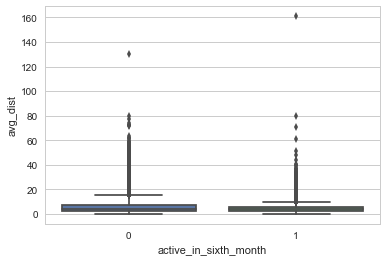

In [71]:
# relationship between avg_dist and active_in_sixth_month
sns.set(style="whitegrid")
ax = sns.boxplot(x="active_in_sixth_month", y="avg_dist", data=df)
plt.show()

Through the plot, avg_dist between 6th month active users and non-active users seems very close. However, a little more users who are not active in the 6th month have avg_dist more than 60.

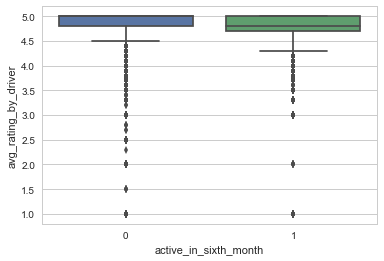

In [72]:
# relationship between avg_rating_by_driver and active_in_sixth_month
sns.set(style="whitegrid")
ax = sns.boxplot(x="active_in_sixth_month", y="avg_rating_by_driver", data=df)
plt.show()

In this boxplot, less active users have very low avg_rating_by_driver, but in the high rating section,
where also most user lying in, active users have lower avg_rating_by_driver than non_active users.

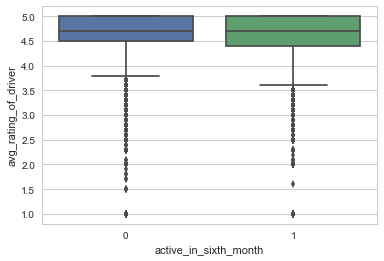

In [73]:
# relationship between avg_rating_of_driver and active_in_sixth_month
sns.set(style="whitegrid")
ax = sns.boxplot(x="active_in_sixth_month", y="avg_rating_of_driver", data=df)
plt.show()

Active users and non_active users share similar avg_rating_of_driver.

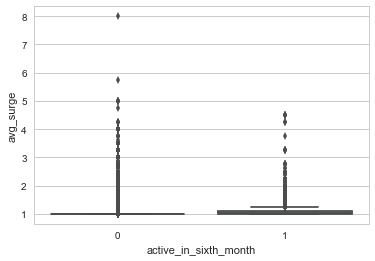

In [74]:
# relationship between avg_surge and active_in_sixth_month
sns.set(style="whitegrid")
ax = sns.boxplot(x="active_in_sixth_month", y="avg_surge", data=df)
plt.show()

Non-active users have more high avg_surge than active users.

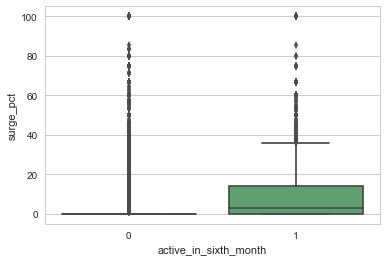

In [75]:
# relationship between surge_pct and active_in_sixth_month
sns.set(style="whitegrid")
ax = sns.boxplot(x="active_in_sixth_month", y="surge_pct", data=df)
plt.show()

Most active users have surge_pct less than 20, but non-active users have a very even surge_pct distribution.

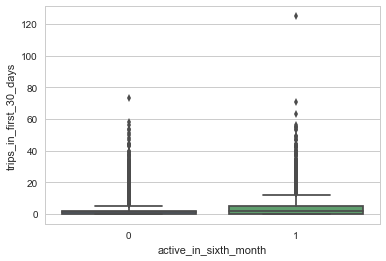

In [76]:
# relationship between trips_in_first_30_days and active_in_sixth_month
sns.set(style="whitegrid")
ax = sns.boxplot(x="active_in_sixth_month", y="trips_in_first_30_days", data=df)
plt.show()

Overall, active users tend to have more trips_in_first_30_days.

In [77]:
X = df.iloc[:, :-1,]
y = df.iloc[:, -1]
X.drop(['last_trip_date', 'signup_date', 'six_month_start', 'six_month_end'], axis=1, inplace=True)
X = pd.get_dummies(X, dummy_na=True)

Question 2:

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

KNN

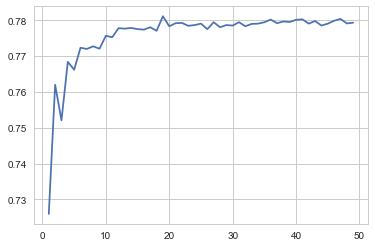

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

v=[]
k_range = list(range(1, 50))
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    k_pred = knn.predict(X_test)
    v.append(metrics.accuracy_score(y_test, k_pred))
plt.plot(k_range,v)
plt.show()

In [80]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)
k_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, k_pred))
matrix = confusion_matrix(y_test, k_pred)
print(matrix)

0.781133333333
[[10349   975]
 [ 2308  1368]]


Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as mt
logres = LogisticRegression()
logres.fit(X_train,y_train)
log_pred = logres.predict(X_test)
print(mt.accuracy_score(log_pred,y_test))
matrix = confusion_matrix(y_test, log_pred)
print(matrix)

0.768533333333
[[10794   530]
 [ 2942   734]]


Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=60, n_jobs=2, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(accuracy_score(y_test, rf_pred))
matrix = confusion_matrix(y_test, rf_pred)
print(matrix)

0.7728
[[9995 1329]
 [2079 1597]]


In [83]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:16} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: avg_dist         Importance: 0.3
Variable: weekday_pct      Importance: 0.15
Variable: avg_rating_by_driver Importance: 0.1
Variable: surge_pct        Importance: 0.1
Variable: avg_rating_of_driver Importance: 0.09
Variable: avg_surge        Importance: 0.08
Variable: trips_in_first_30_days Importance: 0.07
Variable: ultimate_black_user Importance: 0.02
Variable: city_King's Landing Importance: 0.02
Variable: phone_iPhone     Importance: 0.02
Variable: active_in_first_30_days Importance: 0.01
Variable: city_Astapor     Importance: 0.01
Variable: city_Winterfell  Importance: 0.01
Variable: phone_Android    Importance: 0.01
Variable: city_nan         Importance: 0.0
Variable: phone_nan        Importance: 0.0


According to the feature importance list, avg_dist has importance of 0.3, which is way higher than the other features.The average distance in miles per trip taken in the first 30 days after signup plays a key role in predict whether the user would be active in their 6th month on the system. The percent of the user’s trips occurring during a weekday has importance of 0.15. Therefore, users who use has higher avg_dist and use Ultimate more often during weekdays are more likely to become long term users.